# Student Satisfaction and Academic Performance in Remote Learning

## 1. Background
### 1.1 Introduction 

As we reflected on the challenges faced by students during the COVID-19 pandemic, several key issues emerged. These included unreliable internet connectivity and the absence of appropriate learning devices, which hindered participation in synchronous classes and the submission of course requirements (Baticulon et al., 2020; Santos, 2020). Negative experiences such as limited engagement in synchronous lectures, increased distractions, difficulties in comprehending lessons, and delays in the exchange of responses and feedback also significantly impacted their overall learning experience (Bai et al., 2021). Furthermore, two surveys conducted by the University of the Philippines (UP) System Committee on Remote Teaching and Learning (SCRL) in November 2020 and July 2021 revealed that 80% of students felt academically overwhelmed, while only 30% expressed satisfaction with their learning experiences (Lontoc, 2021).

In response to this dilemma, it is crucial to evaluate the academic effectiveness of prior remote learning systems to assist administrations in their decision-making processes. As highlighted by Joaquin et al. (2020), learning innovations must have a deeper understanding of what remote education is by looking at factors such as the instructor’s capacity, the student’s circumstance, and the learning environment’s efficiency.

### 1.2. Objectives

This report aimed to analyze student experiences with the remote learning setup at the University of the Philippines (UP). It is guided by the following primary objectives:
             
#### 1.2.1.	Describe the profile of the student respondents.
- 1.2.1.1. Detail the demographic characteristics of the respondents, particularly their constituent university, year-level standing, and undergraduate programs.
- 1.2.1.2. Determine the central tendency and dispersion of student satisfaction with remote learning using ratings from the UP Student Satisfaction Scale (UPSSS).
- 1.2.1.3. Ascertain the central tendency and dispersion of students' self-perceived academic performance using ratings from the Student Perception on Academic Performance Scale (SPAPS).

#### 1.2.2.	Examine the relationship between student satisfaction and perceived academic performance.
- 1.2.2.1. Determine the strength and direction of the overall relationship between the sum ratings of the UPSSS and the SPAPS.
- 1.2.2.2. Analyze the pairwise correlations between the individual variables of the UPSSS and the SPAPS.
  
## 2. Exploratory Analysis

In [1]:
## Import data from CSV file
suppressMessages(library(tidyverse)) # required library
data <- read_csv("/kaggle/input/the-data-setlist/survey_data.csv", show_col_types = FALSE)

# Required library
library(dplyr)

## Create functions to be used

# Create horizontal bar plot using base R graphics    
suppressMessages(library(rlang, verbose=FALSE, quiet=TRUE)) # required library               
horiz_barplot <- function(data,
                          variable,
                          summ_var = NULL,
                          summ_fun = "n",
                          na.rm = TRUE,
                          others = FALSE,
                          others.p = NULL,
                          mar = c(5.1, 4.1, 4.1, 2.1),
                          col = "steelblue",
                          title = NULL,
                          xlab = NULL,
                          ylab = NULL,
                          xlim_adj = 0,
                          ...) {

  # --- Data Summarization ---

  # Use dplyr::count() for simple counts.
  if (is.null(summ_fun) || summ_fun == "n" || is.null(summ_var)) {
    summary_col_name <- "Count"
    
    summarized_data <- data %>%
      count(.data[[variable]], name = summary_col_name, sort = TRUE)

  } else {
    # Handle other summary functions (mean, median, etc.)
    summary_col_name <- paste(summ_fun, summ_var, sep = "_")
    
    summarized_data <- data %>%
      group_by(.data[[variable]]) %>%
      summarize(
        !!summary_col_name := get(summ_fun)(.data[[summ_var]], na.rm = na.rm),
        .groups = "drop"
      ) %>%
      arrange(desc(.data[[summary_col_name]]))
  }
  
  # --- "Others" Grouping ---
  if (others && !is.null(others.p)) {
    
    # Identify which rows to keep and which to group into "Others"
    to_keep <- summarized_data %>% filter(.data[[summary_col_name]] > others.p)
    to_group <- summarized_data %>% filter(.data[[summary_col_name]] <= others.p)
    
    # Only proceed if there are categories to group
    if (nrow(to_group) > 0) {
      others_row <- tibble(
        # Set the category name to "Others"
        !!variable := "Others",
        # Sum the values of the grouped categories
        !!summary_col_name := sum(to_group[[summary_col_name]])
      )
      
      # Combine the rows to keep with the new "Others" row
      summarized_data <- bind_rows(to_keep, others_row)
    }
  }

  # --- Prepare Data for Base R Plotting ---
  # `barplot` requires a named vector.
  
  # Ensure the variable column is character for naming
  summarized_data[[variable]] <- as.character(summarized_data[[variable]])
  
  # Create the named vector
  summary_vec <- setNames(summarized_data[[summary_col_name]], summarized_data[[variable]])
  
  # Reverse the vector so the largest bar is at the top of the plot
  summary_vec <- rev(summary_vec)

  # --- Generate Base R Plot ---
  
  # Set graphical margins
  par(mar = mar)
  
  # Display the bar plot
  bar_midpoints <- barplot(
    height = summary_vec,
    col = col,
    horiz = TRUE,
    las = 1, # Make category labels horizontal
    xlab = xlab,
    ylab = ylab,
    xlim = c(0, max(summary_vec) + xlim_adj),
    ...
  )
  
  # Add title and text labels for the bar values
  title(main = title, adj = 0, ...)
  text(
    x = summary_vec,
    y = bar_midpoints,
    labels = round(summary_vec, 1), # Round labels for cleanliness
    pos = 4, # Position labels to the right of the bars
    ...
  )
  
  # Return the bar midpoints, which can be useful
  invisible(bar_midpoints)
}

# Create custom mode function
mode <- function(x) {
  uniq_vals <- unique(x)
  uniq_vals[which.max(tabulate(match(x, uniq_vals)))]
}
              
            
## Data Understanding

# View the data
head(data)
tail(data)

# View column names
colnames(data)

# Check for missing values
paste("𝗡𝘂𝗺𝗯𝗲𝗿 𝗼𝗳 𝗡𝗔 𝘃𝗮𝗹𝘂𝗲𝘀:", sum(is.na(data)))


## Data Preparation

# Define the standardization function for program variable
standardize_program <- function(input_text) {
  cleaned <- str_to_title(input_text)
    
  cleaned <- str_replace_all(cleaned, "Bs ", "BS ")
  cleaned <- str_replace_all(cleaned, "Vs ", "BS ")
  cleaned <- str_replace_all(cleaned, "Ba ", "BA ")
  cleaned <- str_replace_all(cleaned, " Of ", " of ")
  cleaned <- str_replace_all(cleaned, " In ", " in ")
  cleaned <- str_replace_all(cleaned, " And ", " and ")
  cleaned <- str_replace_all(cleaned, "BS in", "BS")
  cleaned <- str_replace_all(cleaned, "Bachelor of Science in", "BS")
  cleaned <- str_replace_all(cleaned, "Bachelor of", "B")

  if (str_detect(cleaned, "^BA Social Science") &&
      str_detect(cleaned, "Economics")) {
    return("BA Social Sciences (Economics)")
  } else if (str_detect(cleaned, "^B Secondary Education")) {
    return("B Secondary Education")
  } else if (str_detect(cleaned, "^BS Biology")) {
    return("BS Biology")
  } else if (str_detect(cleaned, "^Bfa")) {
    return("B Fine Arts")
  } else {
    return(cleaned)
  }
}

# Clean the data
data <- data %>%
    mutate(
        program = sapply(program, standardize_program), # Standardize program column
        constituent = str_replace(constituent, "Banos", "Baños"), # "Banos" to "Baños" in constituent column
        year_standing = factor(year_standing, levels = c("I", "II", "III", "IV", "V"), ordered = TRUE)  
    )        


## Feature Understanding

# Create a dataframe of descriptions for student information
studentInfo_descr <- data.frame(
    variable = c("id", "constituent", "program", "year_standing", "lms"),
    description = c(
        "Unique identification number assigned to a student participant",
        "UP constituent university where a student was enrolled at the time of the survey",
        "Degree program of a student at the time of the survey",
        "Year level standing of a student at the time of the survey",
        "Learning Management System/s used by a student in virtual classes at the time of the survey"
    )
)

# Subset data of student information
studentInfo_wide <- data[, studentInfo_descr$variable]
              
# Create a dataframe of descriptions for UPSSS variables
upsss_descr <- data.frame(
    item_code = c(
        "upsss1", "upsss2", "upsss3", "upsss4", "upsss5", "upsss6", "upsss7", "upsss8", 
        "upsss9", "upsss10", "upsss11", "upsss12", "upsss13", "upsss14", "upsss15", 
        "upsss16", "upsss17", "upsss18", "upsss19", "upsss20"
    ),

    variable = c(
      "lms_org", "lms_stable", "lms_prog_track",
      "prof_content", "prof_tools_eff",
      "course_workload", "course_announce",
      "course_req_time", "course_feedback_time",
      "sync_stable", "prof_compassion",
      "lib_content", "lib_update", "uni_services",
      "reg_smooth", "enlist_success", "sem_length",
      "uni_response", "setup_conducive", "sat_overall"
    ),
    
    short_description = c(
        "Organization of the LMS", "Stability and reliability of the LMS", "LMS capability for progress tracking",
        "Provision of necessary learning content", "Instructors' effective use of tools",
        "Reasonableness of the course workload", "Timeliness of course announcements",
        "Sufficient time to complete requirements", "Timeliness of feedback on submissions",
        "Stability of synchronous classes", "Instructors' compassion for student concerns",
        "Availability of needed online library content", "Timeliness of online library content", "Utility of university-provided services", 
        "Smoothness of the registration process", "Success in enlisting required courses", "Adequacy of the semester's length",
        "University's response to student concerns", "Conduciveness of the remote learning setup", "Overall satisfaction with remote learning setup"
    ),
    
    full_description = c(
        "Most of my professors organized a platform (e.g. UVLe, Google Classroom, Canvas, etc.) in such a way that I can easily find the content that I need.",
        "Most of my professors used a platform (e.g. UVLe, Google Classroom, Canvas, etc.) that is reliable, stable, and secure.",
        "Most of my professors used a platform (e.g. UVLe, Google Classroom, Canvas, etc.) for me to keep track of my learning progress.",
        "Most of my professors provided the content that I need to learn the lessons (e.g. lecture notes, zoom recordings, video lectures, etc.).",
        "In general, my professors utilized the available tools and platforms effectively.",
        "Most of my professors assigned a reasonable amount of course requirements.",
        "Most of my professors announced the details of requirements according to the date stated in the course schedule.",
        "Most of my professors gave a sufficient amount of time to accomplish the course requirements.",
        "Most of my professors provided feedback to my submissions in a justifiable time.",
        "Most of my professors carried out synchronous classes in a stable and smooth manner.",
        "Most of my professors were compassionate in hearing the students' concerns about their courses and current well-being.",
        "I accessed the university's online library which provides the content that I need (e.g. journals, references, etc.).",
        "I accessed the university's online library which provides up-to-date content.",
        "I used the available services provided by the university in my study (e.g. UP mail can be used to access free Office, Canva for Education, unlimited Google Drive storage, etc.).",
        "The university's registration process was smooth and straightforward.",
        "I enlisted all the subjects that I needed in this semester.",
        "The semester's length is adequate.",
        "The university hears the students' concerns when it comes to issues such as academic ease due to our current situation.",
        "I believe the university's remote learning setup was organized in a way that is conducive to learning.",
        "As a whole, I am satisfied with the university's remote learning setup this semester."
    )
)

# Subset UPSSS data  
upsss_wide <- data[, names(data) == "id" | grepl("upsss", names(data))]
upsss_items <- (colnames(data))[grepl("upsss", colnames(data))]
              
# Required libraries
suppressMessages(library(tidyr, verbose=FALSE, quiet=TRUE))
suppressMessages(library(reshape2, verbose=FALSE, quiet=TRUE))

# Reshape data
upsss_long <- melt(
        upsss_wide,
        id.vars="id",
        variable.name="item_code",
        value.name="rating"
    ) %>%
    left_join(upsss_descr, by="item_code") %>%
    mutate(item_code = factor(item_code, levels=upsss_items, ordered = TRUE)) %>%
    inner_join(studentInfo_wide, "id")

# Create a dataframe of descriptions for SPAPS variables
spaps_descr <- data.frame(
    item_code = c(
        "spaps1", "spaps2", "spaps3", "spaps4", "spaps5", "spaps6", "spaps7"
     ),

    variable = c(
        "req_submit_time",
        "critical_thinking",
        "feedback_exchange",
        "feedback_apply",
        "course_obj_achieve",
        "study_daily",
        "gwa_expected"
    ),
    
    short_description = c(
        "Timely submission of requirements",
        "Application of critical thinking",
        "Providing and receiving feedback", 
        "Application of received feedback", 
        "Achievement of course objectives",        
        "Maintenance of a daily study habit",
        "Expectation of high GWA (1.75 or better)"        
    ),
    
    full_description = c(
        "I was able to submit all my requirements this semester on time.",
        "I was able to think critically and logically while doing my requirements.",
        "I was able to provide and receive feedback on my requirements.",
        "I was able to apply the feedback that I received.",
        "I was able to achieve all of my courses’ objectives.",
        "I made sure that I study for my courses every day.",
        "I believe I can get a general weighted average (GWA) of at least 1.75 this semester."
    )
        
)

# Subset SPAPS data  
spaps_wide <- data[, names(data) == "id" | grepl("spaps", names(data))]
spaps_items <- (colnames(data))[grepl("spaps", colnames(data))]

# Reshape data
spaps_long <- melt(
        spaps_wide,
        id.vars="id",
        measure.vars=spaps_items,
        variable.name="item_code",
        value.name="rating"
    ) %>%
    left_join(spaps_descr, by="item_code") %>%
    mutate(item_code = factor(item_code, levels = spaps_items, ordered=TRUE)) %>%
    inner_join(studentInfo_wide, "id")

id,constituent,program,year_standing,lms,upsss1,upsss2,upsss3,upsss4,upsss5,⋯,upsss18,upsss19,upsss20,spaps1,spaps2,spaps3,spaps4,spaps5,spaps6,spaps7
<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
001,UP Diliman,BS Statistics,III,UVLê,6,5,6,6,6,⋯,1,3,3,5,3,4,3,2,3,5
002,UP Diliman,BS Geology,IV,UVLê;Google Classroom,5,4,6,2,4,⋯,1,1,2,2,3,3,4,3,1,1
003,UP Diliman,B Music,V,UVLê;Google Classroom,6,6,6,7,7,⋯,1,5,6,5,7,7,7,7,4,7
004,UP Diliman,BS Statistics,IV,UVLê,6,7,7,5,6,⋯,1,2,1,4,5,5,5,5,4,5
005,UP Diliman,BS Biology,II,UVLê,7,7,7,7,7,⋯,2,3,4,4,6,6,6,5,4,7
006,UP Diliman,BS Statistics,IV,UVLê;Google Classroom,7,7,7,6,5,⋯,3,4,5,5,2,3,4,5,6,4


id,constituent,program,year_standing,lms,upsss1,upsss2,upsss3,upsss4,upsss5,⋯,upsss18,upsss19,upsss20,spaps1,spaps2,spaps3,spaps4,spaps5,spaps6,spaps7
<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
145,UP Diliman,BS Statistics,III,UVLê,6,6,6,6,6,⋯,5,5,5,3,6,5,5,4,4,4
146,UP Diliman,BS Mechanical Engineering,III,UVLê;Google Classroom,7,7,7,5,5,⋯,3,2,2,2,4,3,5,1,4,3
147,UP Los Banos,BS Biology,II,eLBI;Google Classroom;Canvas;Moodle,7,7,7,7,7,⋯,1,2,1,1,3,2,1,3,1,7
148,UP Diliman,BS Computer Science,II,UVLê;Google Classroom,6,7,6,7,7,⋯,2,4,4,6,6,6,5,4,5,5
149,UP Diliman,BS Statistics,IV,UVLê;Google Classroom,7,7,6,7,7,⋯,1,5,3,6,7,5,7,5,2,7
150,UP Diliman,BS Business Administration and Accountancy,IV,UVLê;Google Classroom,5,5,6,5,4,⋯,1,2,2,7,6,2,2,4,2,1


[1] "id"            "constituent"   "program"       "year_standing"
 [5] "lms"           "upsss1"        "upsss2"        "upsss3"       
 [9] "upsss4"        "upsss5"        "upsss6"        "upsss7"       
[13] "upsss8"        "upsss9"        "upsss10"       "upsss11"      
[17] "upsss12"       "upsss13"       "upsss14"       "upsss15"      
[21] "upsss16"       "upsss17"       "upsss18"       "upsss19"      
[25] "upsss20"       "spaps1"        "spaps2"        "spaps3"       
[29] "spaps4"        "spaps5"        "spaps6"        "spaps7"

[1] "𝗡𝘂𝗺𝗯𝗲𝗿 𝗼𝗳 𝗡𝗔 𝘃𝗮𝗹𝘂𝗲𝘀: 0"

### 2.1. Descriptive Statistics
#### 2.1.1. Demographics

##### 2.1.1.1. Constituent University
Among the 150 surveyed UP students, 103 (68.7%) were from **Diliman** and 30 (20.0%) were from **Los Baños**. The remaining 17 respondents were from five other constituent universities: 5 (3.3%) from **Manila**, 4 (2.7%) from **Baguio**, 3 (2.0%) each from the **Open University** and **Visayas**, and 2 (1.3%) from **Cebu**. This means that analyses by constituent university must be interpreted with extreme caution due to highly skewed sample sizes and findings for campuses with few respondents are merely illustrative and not generalizable.

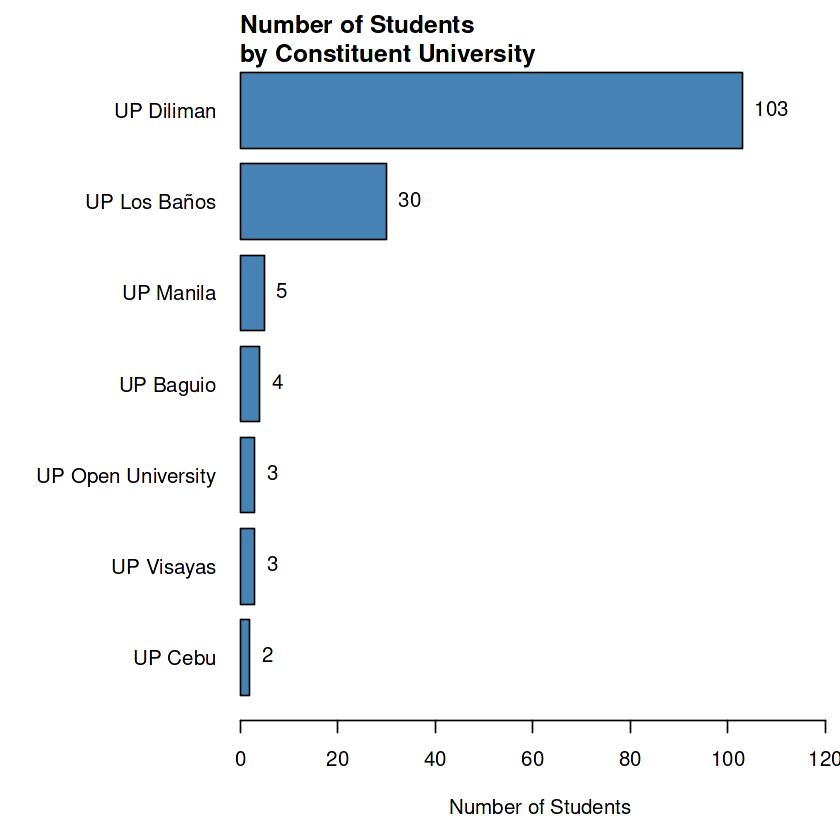

In [2]:
# Display bar plot
# Constituent university
horiz_barplot(
  data = data,
  variable = "constituent",
  title = "\nNumber of Students\nby Constituent University",
  xlab = "Number of Students",
  mar = c(5, 10, 2, 0),
  xlim_adj = 20
)

##### 2.1.1.2. Undergraduate Program
Most of the respondents, totaling 66 (44.0%), were **BS Statistics** majors. The remaining 84 respondents came from a variety of other programs, including:
- 7 (4.7%) from **BS Biology**;
- 6 (4.0%) from **BS Secondary Education**;
- 5 (3.3%) each from **three BS engineering programs (Civil, Computer Science, and Geodetic)**,
- 3 (2.0%) each from **five BS programs: Business Economics, Development Communication, Economics, Mechanical Engineering, and Nursing**;
- 2 (1.3%) each from **eight other programs**;
- 1 (0.7%) each from **25 other programs**.

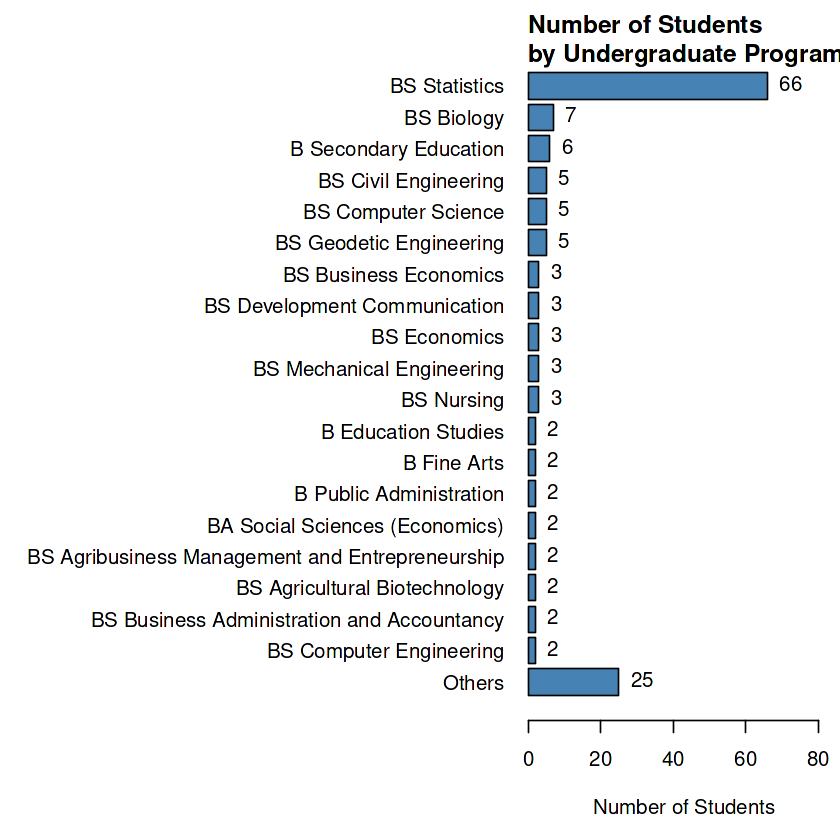

In [3]:
# Display bar plot
# Undergraduate program
horiz_barplot(
  data = data,
  variable = "program",
  others = TRUE,
  others.p = 1,
  title = "\nNumber of Students\nby Undergraduate Program",
  xlab = "Number of Students",
  mar = c(5, 22, 2, 0),
  xlim_adj = 20
)

##### 2.1.1.3. Year-Level Standing
**Seniors** made up the largest group with **52 (34.7%)** students, followed by **juniors** (46 or 30.7%), **sophomores** (31 or 20.7%), **freshmen** (17, 11.3%), and **fifth-year students** (4, 2.7%).

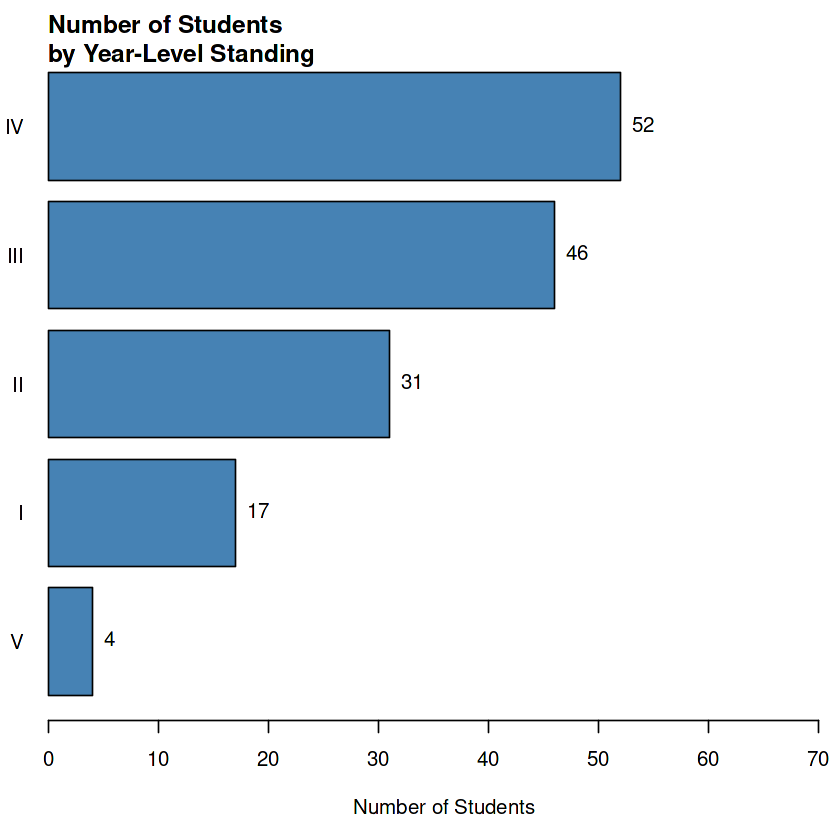

In [4]:
# Display bar plot
# Undergraduate program
horiz_barplot(
  data = data,
  variable = "year_standing",
  others = TRUE,
  others.p = 1,
  title = "\nNumber of Students\nby Year-Level Standing",
  xlab = "Number of Students",
  mar = c(5, 2, 2, 0),
  xlim_adj = 20
)

#### 2.1.2. Student Satisfaction with Remote Learning

##### 2.1.2.1. Overall
Based on data from student ratings on a scale of 1 (Strongly Disagree) to 7 (Strongly Agree) for statements in the **20-item UP Student Satisfaction Scale (UPSSS)**, the **overall median rating sum was 94 out of 140**, with an **average of 4.7 out of 7** per item. This shows that student satisfaction with remote learning ranges from neutral to somewhat positive.

In [5]:
# Aggregate student ratings
agg_data <- upsss_long %>%
    group_by(id) %>%
    summarize(upsss_ratingSum=sum(rating)) %>%
    inner_join(
        spaps_long %>%
            group_by(id) %>%
            summarize(spaps_ratingSum=sum(rating)),
        by="id"
    ) %>%
    inner_join(studentInfo_wide, by="id")

# Compute median
med_upsss_ratingSum <- median(agg_data$upsss_ratingSum)

# Display summary outputs
data.frame(med_ratingSum = med_upsss_ratingSum, avg_med_ratingSum = med_upsss_ratingSum/20)

med_ratingSum,avg_med_ratingSum
<dbl>,<dbl>
94,4.7


##### 2.1.2.2. Variables

The most positively rated item was **access to university digital services** (e.g., Office 365, Canva for Education, Google Drive, etc.), with a **median and mode of 7 (Strongly Agree)**. The very low **IQR of 1** indicates a strong and widespread consensus on the value of these tools. Similarly, aspects of a **Learning Management System (LMS)** were rated highly with a **median of 6 (Agree)**, including its **organization, stability, and progress tracking capability**. **Instructor-related** items also received strong positive feedback; students generally agreed with a **median of 6 (Agree)** that their **professors were compassionate, provided necessary learning content, announced requirements on time, and used tools effectively**. The consensus on these points was relatively high, with **IQRs ranging from 1 to 2**.

The **time provided for requirements and the overall course workload** both received a **median rating of 5 (Somewhat Agree)**, with the latter having a high **IQR of 3**. This means that while the average student 'Somewhat Agreed' that the workload was reasonable, a considerable number of students disagreed, making this a point of contention. Similarly, the **stability of synchronous classes and the smoothness of registration** both had a **median rating of 5 (Somewhat Agree)**; high **IQRs of 2 to 3** indicate inconsistent student experiences.

The **timeliness of course feedback** presented a mixed to negative sentiment from most students, with a neutral **median of 4 (Neutral)** and a **mode of 2 (Disagree)**. The university's **online library** was another area of concern, as both the **availability of needed content and its up-to-dateness** received a neutral **median of 4 (Neutral)** and a **mode of 1 (Strongly Disagree)**. Among the most critically rated items were the **university's response to addressing student concerns and the adequacy of the semester's length**, which received **median ratings of 2 (Disagree)** and **3 (Somewhat Disagree)**, respectively. Notably, both items shared a **mode of 1 (Strongly Disagree)**, indicating a strong level of disagreement for each. Finally, broader items of **conduciveness and overall satisfaction** obtained a **median rating of 3 (Somewhat Disagree)**, suggesting a slightly negative general view of the remote learning experience.

item_code,variable,n_students,min_rating,med_rating,mode_rating,max_rating,iqr
<ord>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
upsss14,uni_services,150,1,7,7,7,1.00
upsss7,course_announce,150,1,6,6,7,1.00
upsss16,enlist_success,150,1,6,7,7,3.00
upsss1,lms_org,150,1,6,6,7,1.00
upsss3,lms_prog_track,150,1,6,6,7,2.00
upsss2,lms_stable,150,1,6,7,7,1.00
upsss11,prof_compassion,150,1,6,6,7,2.00
upsss4,prof_content,150,2,6,7,7,2.00
upsss5,prof_tools_eff,150,2,6,6,7,1.75


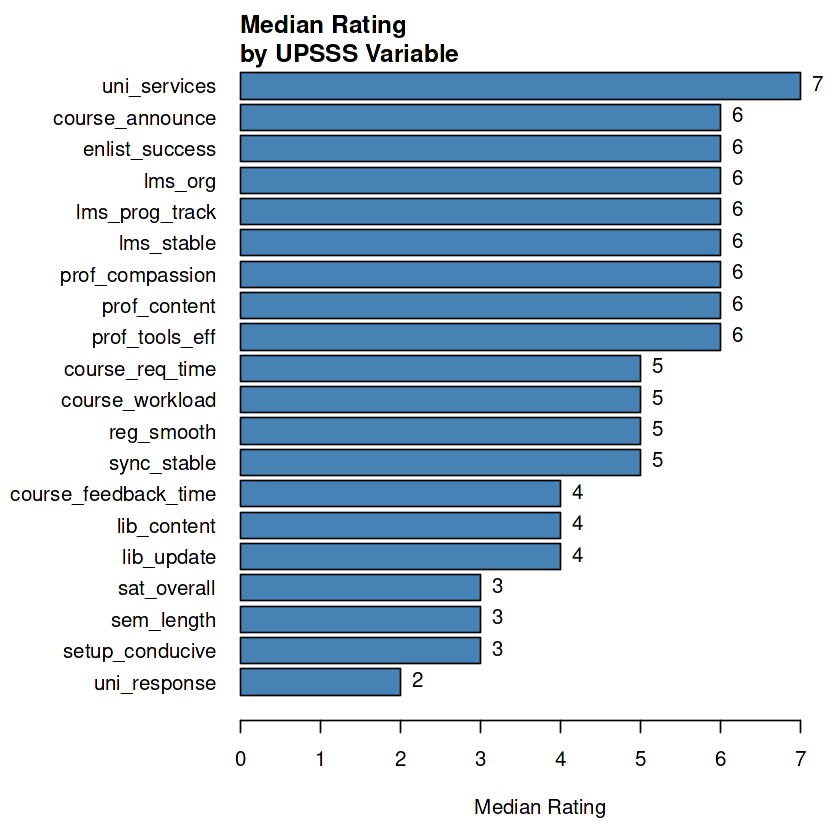

In [6]:
# Display summary statistics
upsss_long %>%
    group_by(item_code, variable) %>%
    summarize(n_students = n(),
              #mean_rating = mean(rating),
              min_rating = min(rating), 
              med_rating = median(rating),
              mode_rating = mode(rating),
              max_rating = max(rating),         
              iqr = IQR(rating),
              .groups = "keep"  
    ) %>%
    arrange(desc(med_rating), variable)

# Display bar plot
horiz_barplot(
  data = upsss_long,
  variable = "variable",
  summ_var="rating",
  summ_fun="median",
  title = "\nMedian Rating\nby UPSSS Variable",
  xlab = "Median Rating",
  mar = c(5, 10, 2, 0),
  xlim_adj = 0.5
)

##### 2.1.2.2. Demographics
###### 2.1.2.2.1. Constituent University

**UP Open University (UPOU)** students reported the highest satisfaction with a **median rating of 6 (Agree)**. As a long-standing distance education constituent, UPOU may have more established and effective systems for remote learning, which is reflected in this higher rating. Most other campuses, including the largest sample from **UP Diliman**, had a **median rating of 5 (Somewhat Agree)**. This indicates a generally positive but not enthusiastic level of satisfaction across the system. Notably, while their **medians were 5 (Somewhat Agree)**, both **UP Los Baños** and **UP Manila** had a **mode of 7 (Strongly Agree)**, suggesting a polarized experience where the most common response was highly positive, even if the central tendency was lower. In contrast, **UP Visayas** was the only campus with a neutral **median rating of 4 (Neutral)**, and its **mode was 3 (Somewhat Disagree)**. This indicates that students from UP Visayas may have experienced the most significant challenges and lowest satisfaction with the remote learning setup compared to their peers in other constituent universities.

constituent,n_students,min_upsss_rating,med_upsss_rating,mode_upsss_rating,max_upsss_rating,iqr
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
UP Open University,3,1,6,6,7,3.00
UP Baguio,4,1,5,5,7,2.00
UP Cebu,2,1,5,5,7,3.00
UP Diliman,103,1,5,6,7,3.00
UP Los Baños,30,1,5,7,7,3.00
UP Manila,5,1,5,7,7,2.25
UP Visayas,3,1,4,3,7,2.00


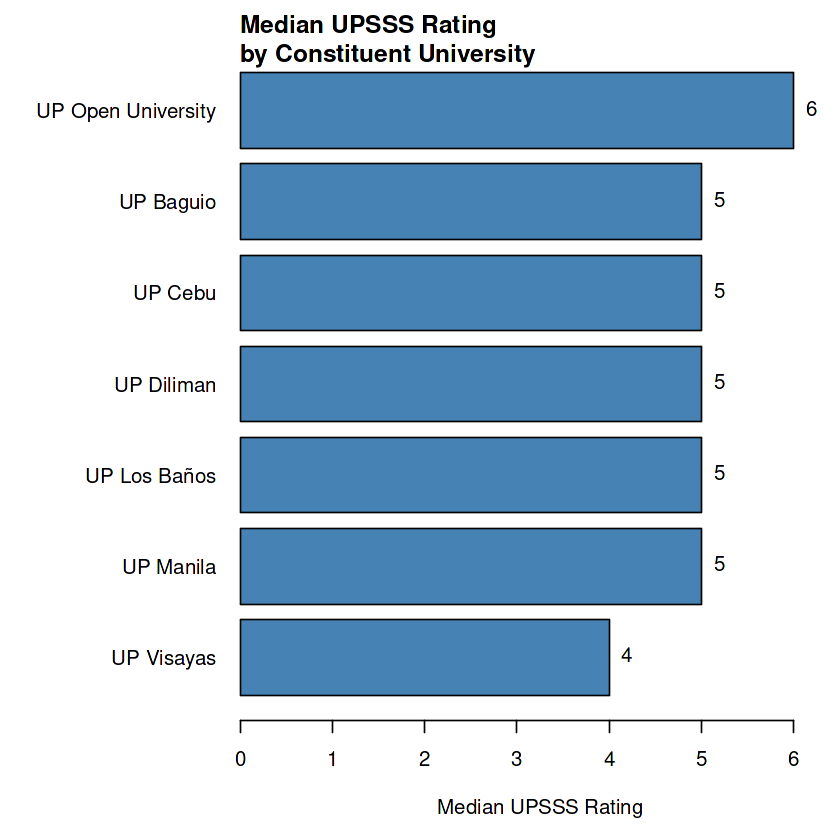

In [7]:
# Display summary statistics
upsss_long %>%
    group_by(constituent) %>%
    summarize(n_students = n()/20,
              min_upsss_rating = min(rating), 
              med_upsss_rating = median(rating),
              mode_upsss_rating = mode(rating),
              max_upsss_rating = max(rating),
              iqr = IQR(rating),
              .groups = "keep"  
    ) %>%
    arrange(desc(med_upsss_rating))

# Display bar plot
horiz_barplot(
  data = upsss_long,
  variable = "constituent",
  summ_var="rating",
  summ_fun="median",
  title = "\nMedian UPSSS Rating\nby Constituent University",
  xlab = "Median UPSSS Rating",
  mar = c(5, 10, 2, 0),
  xlim_adj = 0.5
)

###### 2.1.2.2.2. Year-Level Standing

Satisfaction was highest among **first-year students**, who reported a **median rating of 6 (Agree)**, indicating a more positive outlook on the remote learning experience compared to students in upper years, whose median ratings were consistently **5 (Somewhat Agree)**.

year_standing,n_students,min_upsss_rating,med_upsss_rating,mode_upsss_rating,max_upsss_rating,iqr
<ord>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
I,17,1,6,6,7,2
II,31,1,5,7,7,3
III,46,1,5,6,7,3
IV,52,1,5,6,7,2
V,4,1,5,7,7,3


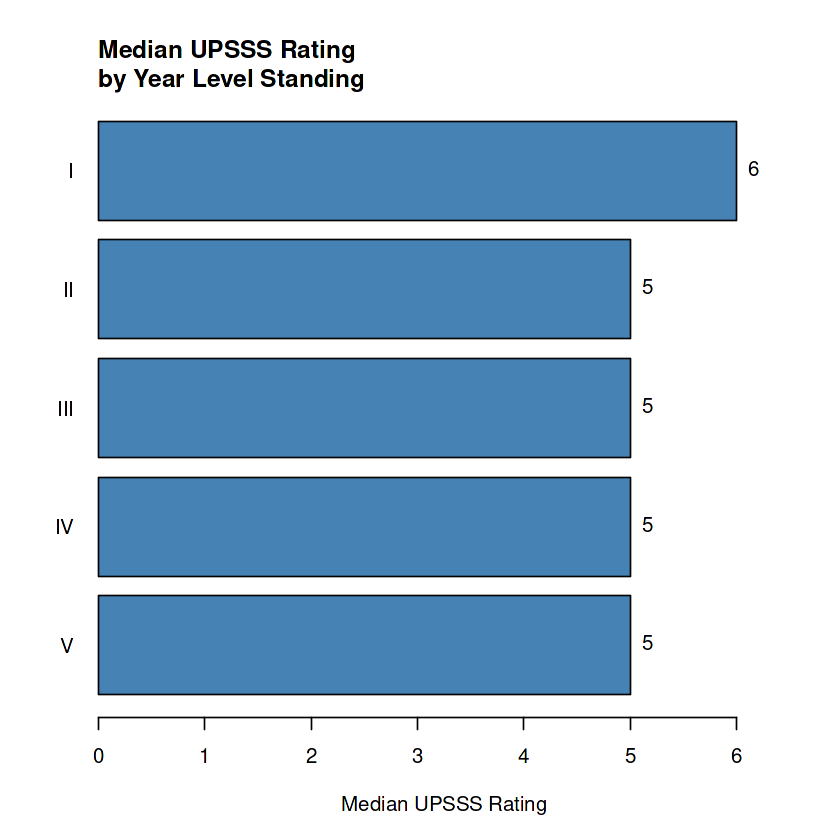

In [8]:
# Display summary statistics
upsss_long %>%
    group_by(year_standing) %>%
    summarize(n_students = n()/20,
              min_upsss_rating = min(rating), 
              med_upsss_rating = median(rating),
              mode_upsss_rating = mode(rating),
              max_upsss_rating = max(rating),
              iqr = IQR(rating),
              .groups = "keep"  
    ) %>%
    arrange(desc(med_upsss_rating))

# Display bar plot
horiz_barplot(
  data = upsss_long,
  variable = "year_standing",
  summ_var="rating",
  summ_fun="median",
  title = "\nMedian UPSSS Rating\nby Year Level Standing",
  xlab = "Median UPSSS Rating",
  xlim_adj = 0.5
)

#### 2.1.3. Perceived Academic Performance
##### 2.1.3.1. Overall
Based on student ratings on a scale of 1 (Strongly Disagree) to 7 (Strongly Agree) for statements in the **7-item Student Perception on Academic Performance Scale (SPAPS)**, the **overall median rating sum was 30 out of 49** (or an **average of 4.3 out of 7** per item), indicating a neutral to slightly positive perception of academic performance.

In [9]:
# Aggregate student ratings

# Compute median
med_spaps_ratingSum <- median(agg_data$spaps_ratingSum)

# Display summary outputs
data.frame(med_ratingSum = med_spaps_ratingSum, avg_med_ratingSum = round(med_spaps_ratingSum/7, 1))

med_ratingSum,avg_med_ratingSum
<dbl>,<dbl>
30,4.3


##### 2.1.3.2. Variables

Students reported their most positive perception on academic performance with both the **timely submission of requirements** and the **achievement of a high GWA** receiving a **median rating of 5 (Somewhat Agree)**. However, a high **IQR of 3** for both items indicates this was not universal. For the majority of items, the **median rating was 4 (Neutral)**. The consistently high **IQRs (ranging from 2 to 3)** suggest that while students feel they are managing to produce final outputs, they are less certain about the **quality and consistency** of the related **academic processes, skills, and habits.**

item_code,variable,min_rating,med_rating,max_rating,iqr
<ord>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
spaps7,gwa_expected,1,5,7,3.00
spaps1,req_submit_time,1,5,7,3.00
spaps5,course_obj_achieve,1,4,7,2.00
spaps2,critical_thinking,1,4,7,2.00
spaps4,feedback_apply,1,4,7,2.75
spaps3,feedback_exchange,1,4,7,2.00
spaps6,study_daily,1,4,7,3.00


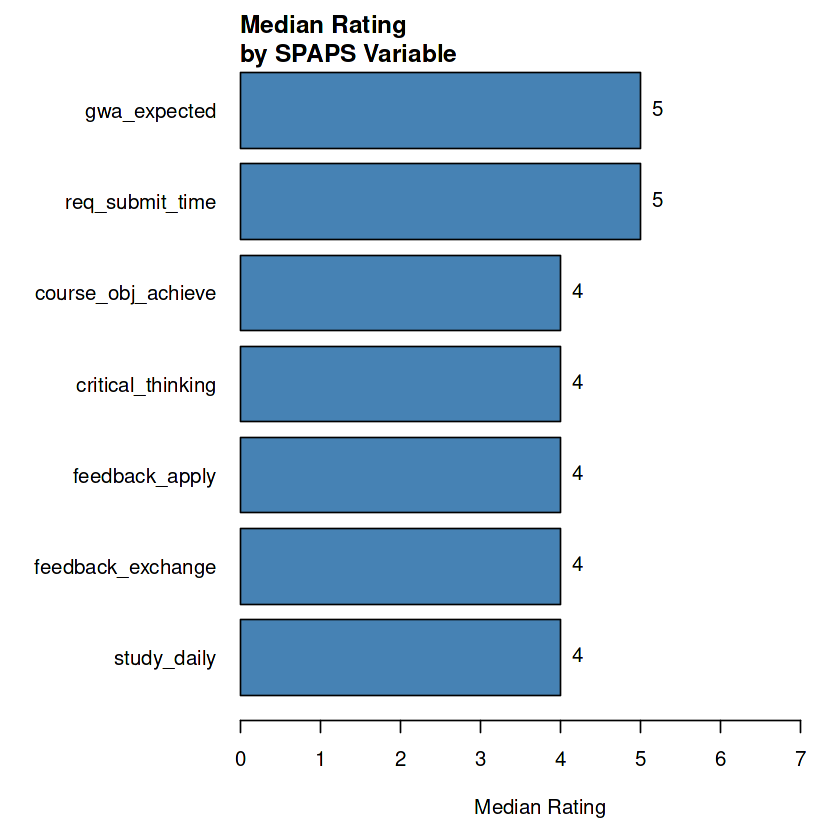

In [10]:
# Display summary statistics
spaps_long %>%
    group_by(item_code, variable) %>%
    summarize(min_rating = min(rating), 
              med_rating = median(rating),
              max_rating = max(rating),
              iqr = IQR(rating),
              .groups = "keep"  
    ) %>%
    arrange(desc(med_rating), variable)

# Display bar plot
horiz_barplot(
  data = spaps_long,
  variable = "variable",
  summ_var="rating",
  summ_fun="median",
  title = "\nMedian Rating\nby SPAPS Variable",
  xlab = "Median Rating",
  mar = c(5, 10, 2, 0),
  xlim_adj = 2.5
)

##### 2.1.3.3. Demographics
###### 2.1.3.3.1. Constituent University

Students from **UP Diliman and UP Los Baños**, which constituted the largest proportions of the sample, both reported a **median rating of 4 (Neutral)**, suggesting the typical student at these campuses felt uncertain about their academic achievement. However, while UP Los Baños had a neutral median of 4, its most frequent response was 5 (Somewhat Agree), indicating a slightly positive skew in perceptions. Conversely, **UP Open University** also had a neutral median but a **mode of 1 (Strongly Disagree)**, highlighting at least one student with a highly negative perception. This variation is underscored by the consistently high **IQRs (≥ 2)** across most campuses, confirming that a wide diversity of self-perceived performance is a characteristic feature within each university.

constituent,n_students,min_spaps_rating,med_spaps_rating,mode_spaps_rating,max_spaps_rating,iqr
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
UP Cebu,2,2,5,5,7,2.75
UP Manila,5,1,5,6,7,2.50
UP Baguio,4,1,4,4,7,2.00
UP Diliman,103,1,4,5,7,2.00
UP Los Baños,30,1,4,5,7,2.00
UP Open University,3,1,4,1,7,4.00
UP Visayas,3,1,4,5,6,2.00


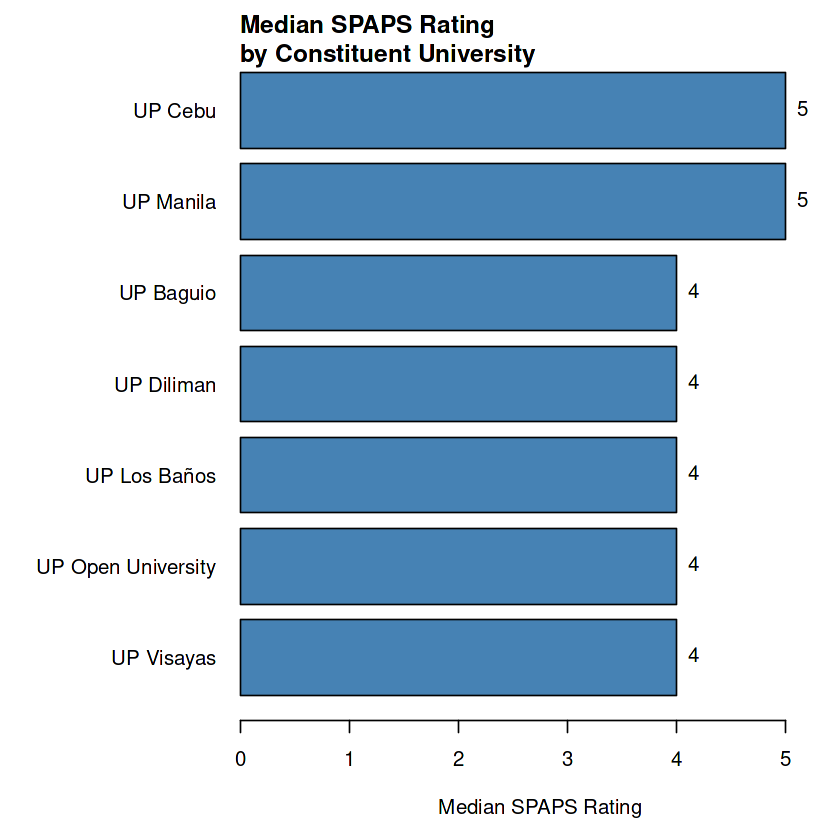

In [11]:
# Display summary statistics
spaps_long %>%
    group_by(constituent) %>%
    summarize(n_students = n()/7,
              min_spaps_rating = min(rating), 
              med_spaps_rating = median(rating),
              mode_spaps_rating = mode(rating),
              max_spaps_rating = max(rating),
              iqr = IQR(rating),
              .groups = "keep"  
    ) %>%
    arrange(desc(med_spaps_rating))

# Display bar plot
horiz_barplot(
  data = spaps_long,
  variable = "constituent",
  summ_var="rating",
  summ_fun="median",
  title = "\nMedian SPAPS Rating\nby Constituent University",
  xlab = "Median SPAPS Rating",
  mar = c(5, 10, 2, 0),
  xlim_adj = 0.5
)

###### 2.1.2.3.2. Year-Level Standing
Perceived academic performance is highest among **first-year students**, who reported a **median rating of 5 (Somewhat Agree)**. This perception declines notably after the first year and then stabilizes, with **sophomore, junior, and senior students** all reporting a consistent, **neutral median of 4**. A slight uptick to a median of 4.5 was observed for **fifth-year students**, though this result must be interpreted with caution due to their much smaller sample size.

year_standing,n_students,min_spaps_rating,med_spaps_rating,mode_spaps_rating,max_spaps_rating,iqr
<ord>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
I,17,1,5.0,5,7,2.00
V,4,1,4.5,7,7,3.25
II,31,1,4.0,3,7,2.00
III,46,1,4.0,5,7,2.00
IV,52,1,4.0,4,7,2.00


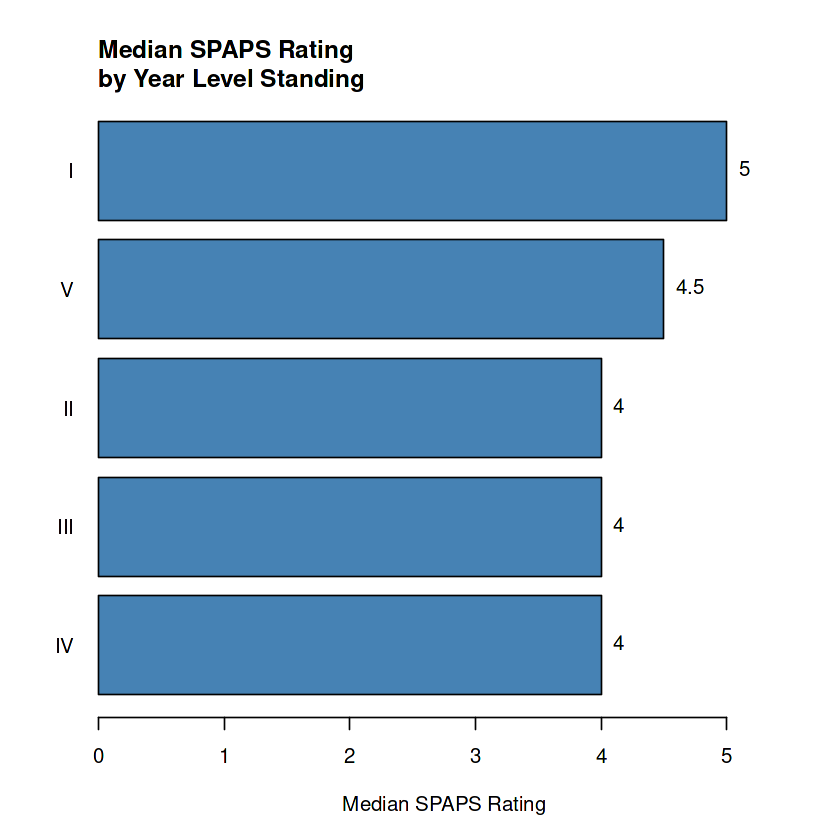

In [12]:
# Display summary statistics
spaps_long %>%
    group_by(year_standing) %>%
    summarize(n_students = n()/7,
              min_spaps_rating = min(rating), 
              med_spaps_rating = median(rating),
              mode_spaps_rating = mode(rating),
              max_spaps_rating = max(rating),
              iqr = IQR(rating),
              .groups = "keep"  
    ) %>%
    arrange(desc(med_spaps_rating))

# Display bar plot
horiz_barplot(
  data = spaps_long,
  variable = "year_standing",
  summ_var="rating",
  summ_fun="median",
  title = "\nMedian SPAPS Rating\nby Year Level Standing",
  xlab = "Median SPAPS Rating",
  xlim_adj = 0.5
)

### 2.2. Correlation Analysis
#### 2.2.1. Overall Correlation
A Spearman's rank-order correlation was used to assess the relationship between student satisfaction and perceived academic performance, with results showing a **statistically significant, moderate positive correlation** **$(p < .001$, $\rho = .51)$** between the two variables. The results of Kendall's rank correlation test **$(p < .001$, $\tau = .37)$** corroborate this finding.

In [13]:
## Test rank correlation of UPSSS and SPAPS rating sums

# Spearman
cor.test(
    x = agg_data$upsss_ratingSum,
    y = agg_data$spaps_ratingSum,
    method="spearman",
    exact=FALSE
)

# Kendall
cor.test(
    x = agg_data$upsss_ratingSum,
    y = agg_data$spaps_ratingSum,
    method="kendall"
)


	Spearman's rank correlation rho

data:  agg_data$upsss_ratingSum and agg_data$spaps_ratingSum
S = 275222, p-value = 2.444e-11
alternative hypothesis: true rho is not equal to 0
sample estimates:
      rho 
0.5106947 



	Kendall's rank correlation tau

data:  agg_data$upsss_ratingSum and agg_data$spaps_ratingSum
z = 6.5459, p-value = 5.915e-11
alternative hypothesis: true tau is not equal to 0
sample estimates:
      tau 
0.3702111 


The accompanying scatterplot below visually represents this relationship, showing the data points forming a broad, elliptical cloud that trends upward from the bottom-left to the top-right. In practical terms, **students who reported higher satisfaction with remote learning tended to report a more positive perception of their own academic performance**.

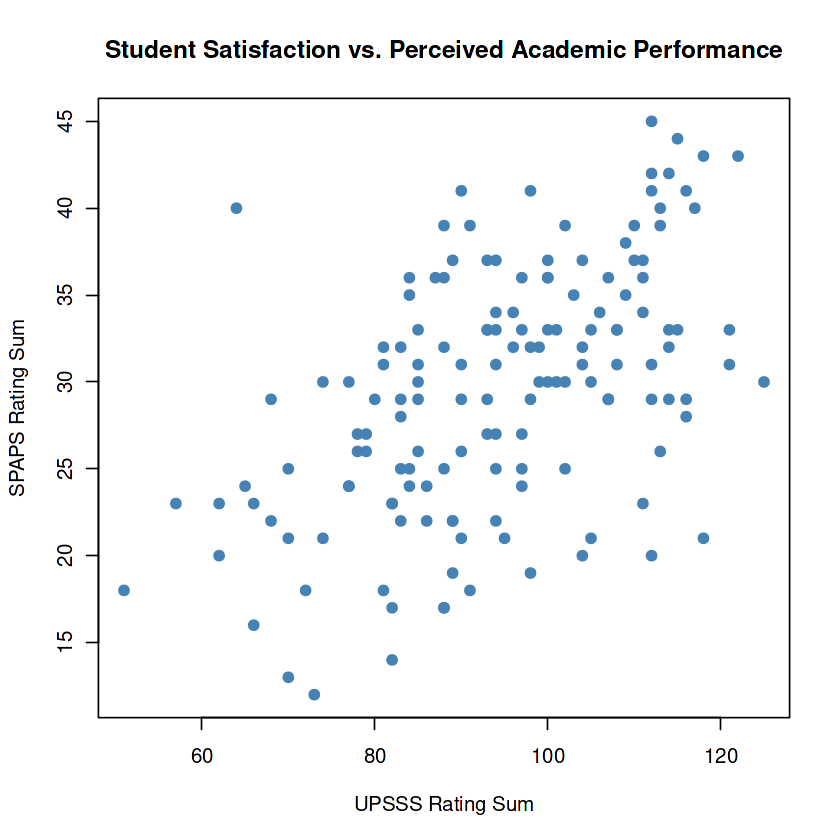

In [14]:
## Display scatterplot
plot(
    x = agg_data$upsss_ratingSum,
    y = agg_data$spaps_ratingSum,
    pch=19,
    col="steelblue",
    main="Student Satisfaction vs. Perceived Academic Performance",
    xlab="UPSSS Rating Sum",
    ylab="SPAPS Rating Sum"
)

#### 2.2.2. Pairwise Correlations

The Spearman's correlation matrix, visualized in the heatmaps below, reveals several key patterns regarding specific pairwise relationships of student satisfaction (UPSSS) and perceived academic performance (SPAPS) variables. **First, the analysis identifies a critical feedback loop.** A strong positive correlation exists between **feedback timeliness and the perceived ability to apply it**, which is supported by a high **Spearman's correlation coefficient $(\rho = .65)$** and the dendrograms that show a tight grouping of the two feedback-related variables. Additionally, **overall satisfaction** with the remote learning setup and its **conduciveness** were most strongly correlated with students' ability to **achieve course objectives and engage in critical thinking** (**Spearman's $\rho$ ranging from 0.39 to 0.48**). In contrast, the SPAPS item on **maintaining a daily study habit** appears to operate independently of institutional satisfaction. It exhibits some of the weakest correlations across the board, showing **near-zero relationships** with most areas.

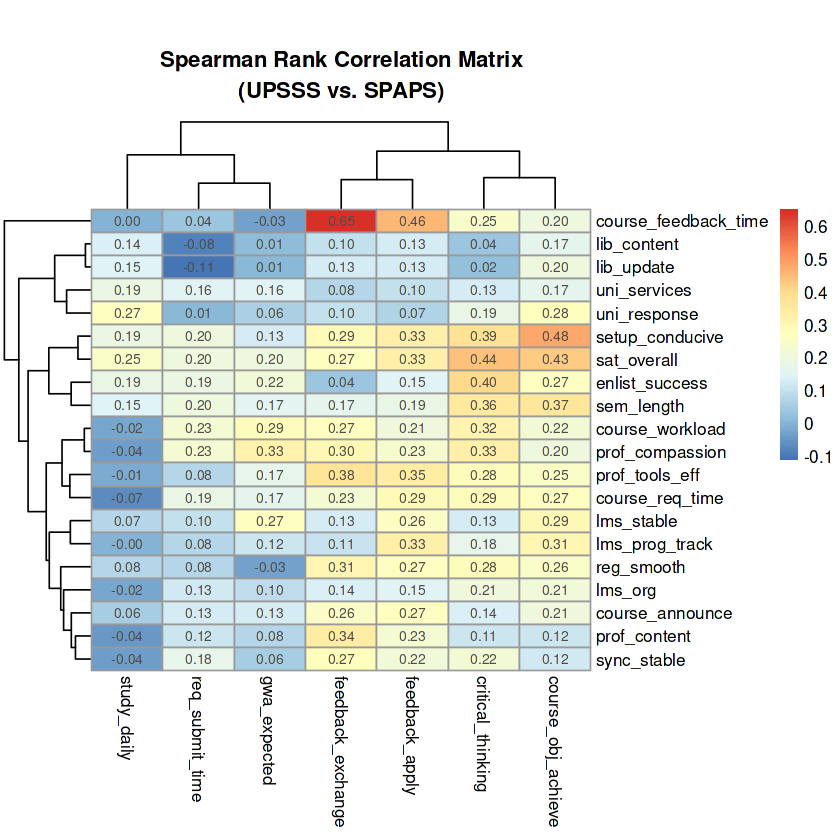

In [15]:
## (UPSSS vs. SPAPS) variables

# Join UPSSS and SPAPS data
upsss_spaps_wide <- upsss_wide %>%
    inner_join(spaps_wide, by="id") %>%
    select(-id)

# Rename columns
colnames(upsss_spaps_wide) <- c(upsss_descr$variable, spaps_descr$variable)

# Calculate the correlation matrices

# Spearman
spearmanCor_matrix <- upsss_spaps_wide %>%
  select(all_of(spaps_descr$variable), all_of(upsss_descr$variable)) %>%
  cor(method="spearman") 

# Kendall
kendallCor_matrix <- upsss_spaps_wide %>%
  select(all_of(spaps_descr$variable), all_of(upsss_descr$variable)) %>%
  cor(method="kendall")

# spearmanCor_matrix[c(8:27), c(1:7)]
# kendallCor_matrix[c(8:27), c(1:7)]

# Generate heatmaps

# Required library
# install.packages("pheatmap")
library(pheatmap)

# Spearman
pheatmap(
  spearmanCor_matrix[c(8:27), c(1:7)],
  main = "\nSpearman Rank Correlation Matrix\n(UPSSS vs. SPAPS)",
  #cluster_rows = FALSE,
  #cluster_cols = FALSE,
  display_numbers = TRUE
)

# # Kendall
# pheatmap(
#   kendallCor_matrix[c(8:27), c(1:7)],
#   main = "\nKendall Rank Correlation Matrix\n(UPSSS vs. SPAPS)",
#   #cluster_rows = FALSE,
#   #cluster_cols = FALSE,
#   display_numbers = TRUE
# )

## 3. References

- Bai, X., Eyob, E., Ola, A., & Reese, S. (2021) "Factors Affecting Students’ Satisfaction with Synchronous Online Instruction During the COVID-19 Pandemic". Journal of International Technology and Information Management: Vol. 30: Iss. 3, Article 4.
DOI: https://doi.org/10.58729/1941-6679.1486.

- Baticulon, R. E., Alberto, N. R., C. Baron, M. B., Mabulay, R. E., Rizada, L. G., Sy, J. J., Tiu, C. J., Clarion, C. A., & Reyes, J. C. (2020). “Barriers to online learning in the time of COVID-19: A national survey of medical students in the Philippines”. DOI: https://doi.org/10.1101/2020.07.16.20155747.

- Joaquin, J. J., Biana, H. T., & Dacela, M. A. (2020). “The Philippine Higher Education Sector in the time of covid-19”. Frontiers in Education, 5. DOI: https://doi.org/10.3389/feduc.2020.576371.

- Lontoc, J. F. B. (2021). UP students and admin meet to assess remote learning and teaching experience. University of the Philippines. Retrieved January 18, 2022, from https://up.edu.ph/up-students-and-admin-meet-to-assess-remote-learning-and-teaching-experience.

- Santos, A. P., By, Shewakramani, J., Zhou, B., & Tsang, C. (2020). “In the Philippines, Distance Learning reveals the digital divide”: Heinrich Böll stiftung: Brussels Office - European Union. Heinrich-Böll-Stiftung. Retrieved January 18, 2022, from https://eu.boell.org/en/2020/10/06/philippines-distance-learning-reveals-digital-divide.